In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
!tar xf spark-2.4.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.1-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder \
   .appName("Neural Network Model") \
   .config("spark.executor.memory", "3gb") \
   .getOrCreate()
   
sc = spark.sparkContext

In [6]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

### 1. Business Understanding

### 2. Data Understanding

#### Data collection - ดึงไฟล์ 2008.csv จาก s3.amazonaws.com มาไว้ใน Linux File System

In [7]:
! wget https://storage.googleapis.com/datascitourism/shared/2008-0.1Mrows.csv

--2022-01-05 15:08:50--  https://storage.googleapis.com/datascitourism/shared/2008-0.1Mrows.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9719482 (9.3M) [text/csv]
Saving to: ‘2008-0.1Mrows.csv’

2008-0.1Mrows.csv   100%[===================>]   9.27M  20.9MB/s    in 0.4s    

2022-01-05 15:08:51 (20.9 MB/s) - ‘2008-0.1Mrows.csv’ saved [9719482/9719482]



#### นับจำนวนบรรทัดในไฟล์ 2008.csv

In [8]:
! wc -l ./2008-0.1Mrows.csv

100000 ./2008-0.1Mrows.csv


#### ดู Content ในไฟล์ 2008.csv

In [9]:
! head -3 2008-0.1Mrows.csv

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,,0,NA,NA,NA,NA,NA
2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,,0,NA,NA,NA,NA,NA


#### Spark อ่านไฟล์ 2008.csv จาก HDFS มาเป็น DataFrame

In [10]:
airline_df = spark.read.format('csv').\
option('header','true').option('mode','DROPMALFORMED')\
.load('./2008-0.1Mrows.csv')

#### Spark นับจำนวน tuple ใน DataFrame

In [11]:
airline_df.count()

99999

#### Spark: Assign ค่าของตัวแปรเก่า ให้กับตัวแปรใหม่

In [12]:
airline_row_df = airline_df

#### Spark แสดง Schema ของข้อมูลใน DataFrame

In [13]:
airline_row_df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

### 3. Data Preparation

#### Spark เรียกใช้ Data Types และ Functions ต่างๆ สำหรับจัดการข้อมูลใน DataFrame

In [14]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf

In [15]:
crunched_df = airline_row_df.\
withColumn('DepTime',airline_row_df['DepTime'].\
           cast(DoubleType())).\
withColumn('TaxiOut',airline_row_df['TaxiOut'].\
           cast(DoubleType())).\
withColumn('TaxiIn',airline_row_df['TaxiIn'].\
           cast(DoubleType())).\
withColumn('DepDelay',airline_row_df['DepDelay'].\
           cast(DoubleType())).\
withColumn('DayOfWeek',airline_row_df['DayOfWeek'].\
           cast(DoubleType())).\
withColumn('Distance',airline_row_df['Distance'].\
           cast(DoubleType())).\
withColumn('ArrDelay',airline_row_df['ArrDelay'].\
           cast(DoubleType()))

#### Spark แสดง Schema ของข้อมูลใน DataFrame หลังจาก cast type แล้ว

In [16]:
crunched_df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

#### Python ติดตั้ง Module "pandas"

In [17]:
! pip install pandas

#### Spark ทำ Data Exploratory โดยใช้สถิติเบื้องต้นกับข้อมูลใน DataFrame

In [18]:
import pandas as pd
pd.DataFrame(crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().take(6),\
             columns=crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().columns).transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
DepTime,98857,1355.1948268711371,464.08827736351554,1.0,2359.0
TaxiOut,98857,10.927460877833639,5.98884616975255,1.0,150.0
TaxiIn,98697,4.768959542843247,2.983650472696529,1.0,213.0
DayOfWeek,99999,3.890058900589006,1.953000092093688,1.0,7.0
Distance,99999,630.5839658396584,437.35862849463183,66.0,2363.0
ArrDelay,98697,5.729900604881608,30.967111608955822,-57.0,500.0


#### Spark ทำ Data Transformation โดยใช้ Data Discretization กับ "DepTime" ใน DataFrame

In [19]:
def t_timeperiod(origin):
    if origin is None:
        period = None
    elif origin > 0 and origin < 600:
        period = '00.01-05.59'
    elif origin >= 600 and origin <=1200:
        period = '06.00-11.59'
    elif origin >= 1200 and origin <= 1800:
        period = '12.00-17.59'
    elif origin >= 1800 and origin <= 2400:
        period = '18.00-24.00'
    else:
        period = 'NA'
    return period

In [20]:
timeperiod = udf(lambda x: t_timeperiod(x),StringType())

In [21]:
discretized_df = crunched_df.\
withColumn('DepTime',timeperiod(crunched_df['DepTime']))

#### Spark ทำ Data Transformation โดยใช้ Data Normalization กับ "Distance" และ "ArrDelay" ใน DataFrame

In [22]:
from pyspark.sql.functions import *
max_distance = discretized_df.select(max('Distance')).collect()[0][0]
min_distance = discretized_df.select(min('Distance')).collect()[0][0]

In [23]:
max_ArrDelay = discretized_df.select(max('ArrDelay')).collect()[0][0]
min_ArrDelay = discretized_df.select(min('ArrDelay')).collect()[0][0]

In [24]:
def t_normalized_distance(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_distance)/(max_distance-min_distance))

In [25]:
def t_normalized_ArrDelay(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_ArrDelay)/(max_ArrDelay-min_ArrDelay))

In [26]:
normalized_distance = udf(lambda x: t_normalized_distance(x),DoubleType())

In [27]:
normalized_ArrDelay = udf(lambda x: t_normalized_ArrDelay(x),DoubleType())

In [28]:
normalized_df = discretized_df.\
withColumn('Distance', normalized_distance(discretized_df['Distance'])).\
withColumn('ArrDelay', normalized_ArrDelay(discretized_df['ArrDelay']))

#### Spark ทำ Feature Selection ด้วยการเลือกเฉพาะบาง Attributes มาเป็น Features

In [29]:
features_df = normalized_df.\
select(['UniqueCarrier','Origin','Dest',\
        'DepTime','TaxiOut','TaxiIn','DepDelay',\
        'DayOfWeek','Distance','ArrDelay'])

#### Spark กำจัดค่า Null ด้วยการลบทั้ง Tuple (Record) เมื่อพบว่ามี Attribute ใดมีค่า Null

In [30]:
final_df = features_df.dropna()

#### Spark นับจำนวน tuple ใน DataFrame

In [31]:
final_df.count()

98697

In [32]:
final_df.show()

+-------------+------+----+-----------+-------+------+--------+---------+-------------------+-------------------+
|UniqueCarrier|Origin|Dest|    DepTime|TaxiOut|TaxiIn|DepDelay|DayOfWeek|           Distance|           ArrDelay|
+-------------+------+----+-----------+-------+------+--------+---------+-------------------+-------------------+
|           WN|   IAD| TPA|18.00-24.00|    8.0|   4.0|     8.0|      4.0| 0.3239007400957771|0.07719928186714542|
|           WN|   IAD| TPA|06.00-11.59|   10.0|   5.0|    19.0|      4.0| 0.3239007400957771| 0.1059245960502693|
|           WN|   IND| BWI|06.00-11.59|   17.0|   3.0|     8.0|      4.0|  0.195472355245973|0.12746858168761221|
|           WN|   IND| BWI|06.00-11.59|    7.0|   3.0|    -4.0|      4.0|  0.195472355245973|0.09156193895870736|
|           WN|   IND| BWI|18.00-24.00|   10.0|   3.0|    34.0|      4.0|  0.195472355245973|0.16337522441651706|
|           WN|   IND| JAX|18.00-24.00|   10.0|   4.0|    25.0|      4.0|0.2707879843273

### 4. Modeling (and making some data transformation )

#### Spark แบ่งข้อมูลเป็น training set และ test set

In [33]:
training_df,test_df = final_df.\
randomSplit([0.80,0.20], seed = 12)

#### Spark นับจำนวน tuple ใน DataFrame

In [34]:
training_df.count()

78826

#### Spark แสดง Schema ของ training set

In [35]:
training_df.printSchema()

root
 |-- UniqueCarrier: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- ArrDelay: double (nullable = true)



#### Transformation categorical variable to numerical one.

In [36]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder

In [37]:
DepTimeIndexer = StringIndexer\
(inputCol='DepTime',outputCol='DepTimeIndexed',handleInvalid='keep')

In [38]:
UniqueCarrierIndexer = StringIndexer\
(inputCol='UniqueCarrier',\
 outputCol='UniqueCarrierIndexed',handleInvalid='keep')

In [39]:
UniqueCarrierOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='UniqueCarrierIndexed',\
 outputCol='UniqueCarrierVec')

In [40]:
OriginIndexer = StringIndexer(inputCol='Origin',\
                              outputCol='OriginIndexed',handleInvalid='keep')

In [41]:
OriginOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='OriginIndexed',\
 outputCol='OriginVec')

In [42]:
DestIndexer = StringIndexer(inputCol='Dest',\
                            outputCol='DestIndexed',handleInvalid='keep')

In [43]:
DestOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='DestIndexed',\
 outputCol='DestVec')

In [44]:
#labelIndexer = StringIndexer(inputCol='ArrDelay',outputCol='labelIndexed')

#### Combines a selected columns into a single vector column.

In [45]:
from pyspark.mllib.linalg import Vectors

In [46]:
from pyspark.ml.feature import VectorAssembler

In [47]:
from pyspark.ml import Pipeline

In [48]:
featureAssembler = VectorAssembler\
(inputCols=['UniqueCarrierIndexed',\
            'OriginVec',\
            'DepTimeIndexed',\
            'TaxiOut','TaxiIn',\
            'DepDelay',\
            'DayOfWeek',\
            'Distance'
           ], outputCol='***features')

#### Define an algorithm.

In [49]:
from pyspark.ml.regression import RandomForestRegressor

In [50]:
dt = RandomForestRegressor\
(labelCol='ArrDelay',featuresCol='***features')

#### Pipeline.

In [51]:
pipeline_dt = Pipeline().\
setStages([UniqueCarrierIndexer,\
           UniqueCarrierOneHotEncoder,\
           DepTimeIndexer,\
           OriginIndexer ,\
           OriginOneHotEncoder,\
           DestIndexer,\
           DestOneHotEncoder,\
           featureAssembler,dt])

In [52]:
#training_df.count()

#### Launch the pipeline and get a model.

In [53]:
dtModel = pipeline_dt.fit(training_df)

#### print out model structure

In [54]:
tree = dtModel.stages[8]

In [55]:
tree.toDebugString

'RandomForestRegressionModel (uid=RandomForestRegressor_ac4b00f9d50c) with 20 trees\n  Tree 0 (weight 1.0):\n    If (feature 84 <= 14.5)\n     If (feature 85 <= 48.5)\n      If (feature 83 <= 20.5)\n       If (feature 8 in {0.0})\n        If (feature 87 <= 0.2261645624727906)\n         Predict: 0.1035988021925752\n        Else (feature 87 > 0.2261645624727906)\n         Predict: 0.09361992509394058\n       Else (feature 8 not in {0.0})\n        If (feature 85 <= 17.5)\n         Predict: 0.09843379480886404\n        Else (feature 85 > 17.5)\n         Predict: 0.14843958898353649\n      Else (feature 83 > 20.5)\n       If (feature 83 <= 36.5)\n        If (feature 82 in {0.0})\n         Predict: 0.11903117428666049\n        Else (feature 82 not in {0.0})\n         Predict: 0.1327009726168273\n       Else (feature 83 > 36.5)\n        If (feature 19 in {1.0})\n         Predict: 0.13332981307424224\n        Else (feature 19 not in {1.0})\n         Predict: 0.18189407540394975\n     Else (fea

### 5. Evaluation

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null

In [56]:
result_df = dtModel.transform(test_df.dropna())

#### แสดงผลลัพธ์เปรียบเทียบระหว่าง Arrival Delay จริง กับ Prediction of Arrival Delay

In [57]:
result_df.select(['ArrDelay','Prediction']).show()

+-------------------+-------------------+
|           ArrDelay|         Prediction|
+-------------------+-------------------+
|0.23518850987432674|0.27487156993479683|
|0.13285457809694792| 0.1271070290892911|
|0.14183123877917414|0.12816878849422794|
|0.09874326750448834|0.09739037096688588|
|0.07001795332136446|0.09214429620524672|
|0.06642728904847396|0.08963797475417203|
|0.05385996409335727|0.08876259583823322|
|0.10951526032315978|0.09104195437623999|
|0.09156193895870736|0.09362285270563515|
|0.09156193895870736|0.09316475758028495|
|0.08976660682226212|0.09749460621493046|
|0.07719928186714542|0.09389691759812219|
|0.19389587073608616| 0.1942488138351401|
|0.08258527827648116|0.09389691759812219|
|0.09156193895870736|0.09390452825349982|
|0.09694793536804308|0.09712091266973777|
|0.10771992818671454|0.09772409025418739|
|0.09156193895870736|0.09316475758028495|
|0.09874326750448834|0.09808255672683192|
|0.10233393177737882|0.09808255672683192|
+-------------------+-------------

#### Plot a Graph

In [58]:
! pip install pandas

In [59]:
#sample for 7000 row from 1361937 millions
lr_prediction_sample = result_df.select("prediction","ArrDelay")
lr_prediction_sample1 = lr_prediction_sample.limit(3500)
lr_prediction_sample2 = lr_prediction_sample1.sort("ArrDelay", ascending=True)
#convert to pandas
lr_prediction_sample_pd = lr_prediction_sample1.toPandas()

In [60]:
print(lr_prediction_sample_pd.info())
lr_prediction_sample_pd.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  3500 non-null   float64
 1   ArrDelay    3500 non-null   float64
dtypes: float64(2)
memory usage: 54.8 KB
None


,prediction,ArrDelay
0,0.274872,0.235189
1,0.127107,0.132855
2,0.128169,0.141831
3,0.097390,0.098743
4,0.092144,0.070018


In [61]:
lr_prediction_sample_pd['id'] = lr_prediction_sample_pd.index

In [62]:
! pip install seaborn

In [63]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

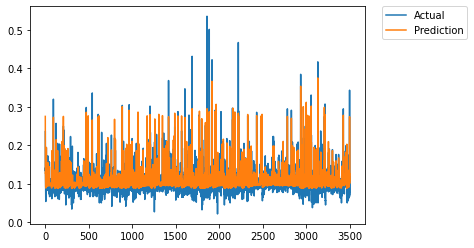

In [64]:
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['ArrDelay'],label='Actual')
#plt.plot(cv_prediction_sample_pd['id'] , cv_prediction_sample_pd['prediction'],label='CV_Prediction')
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['prediction'],label='Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.001)
plt.show()

In [65]:
training_df.count()

78826

#### กรองบาง Tuples (Records) ทิ้งไปจาก testing set

In [66]:
from pyspark.ml.evaluation import RegressionEvaluator

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null และผ่านการกรองฯ แล้ว

In [67]:
everesult_df = dtModel.transform(test_df.dropna())

In [68]:
lr_evaluator_r2 = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="r2")
print("R Squared (R2) on test data = %g" \
      % lr_evaluator_r2.evaluate(everesult_df))

R Squared (R2) on test data = 0.775154


In [69]:
lr_evaluator_rmse = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="rmse")
print("Root Mean Squared Error (RMSE) on test data = %g" \
      % lr_evaluator_rmse.evaluate(everesult_df))

Root Mean Squared Error (RMSE) on test data = 0.0270928
